Inference of Gene Regulatory Network using Kinetic Ising Model


In [38]:
from datetime import date

print("Last run date:", date.today())

Last run date: 2023-03-21


In [39]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')

# from lib.import_funcs import *
import lib.fun_plotting as fun_plotting
import lib.funcs_general as funcs_general
import lib.minibulk_funcs as mb

import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

# matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# plt.rcParams['font.family'] = 'Avenir'
matplotlib.rc('text', usetex=True)
sns.set(font='Avenir')
# plt.rcParams['figure.facecolor'] = 'white'
# set the facecolor of the figure to white
sns.set(style="white")



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initial information

In [40]:
# to save or not all the informations computed here (df with LogNorm, PsiNorm, MB and PST)
saving = True

In [41]:
path      = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/" 
path_data = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/DATA/"

In [42]:
# genes of OUR dataset
genes_order = np.loadtxt(path_data+"general_info/genes_order.csv", dtype="str") #selected genes

# Genes Classification
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative = ["Nr0b1", "Zic3", "Rbpj", "Utf1", "Etv4", "Tcf15"]
committed = ["Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]

# genes in genes_order that are not naive, formative or committed
other = [x for x in genes_order if x not in naive and x not in formative and x not in committed]


In [43]:
# time steps
time=["00h", "06h", "12h", "24h", "48h"]

# load the index of the different time steps
time_sep = np.loadtxt(path_data+"GE_data/time_sep.txt", dtype=np.int32)


# Raw Data

In [44]:
# load raw data
df_raw = pd.read_csv(path_data + "GE_data/imp_genes_raw.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_raw.index.name = None
df_raw.head()


,AAACCCAGTGACCGTC,AAACGAAAGCGCGTTC,AAACGAACAAGCACCC,AAACGAATCAAGTCGT,AAACGCTTCCGTGACG,AAAGAACGTCAGATTC,AAAGAACTCACTTGTT,AAAGGATCAAATCAAG,AAAGGATTCTGAACGT,AAAGGGCAGCAGGCAT,...,TTTGACTGTCAGCTTA,TTTGACTGTGTTATCG,TTTGACTTCGCCACTT,TTTGATCGTTCTCCAC,TTTGGTTAGAGAGCGG,TTTGGTTGTGATCATC,TTTGGTTTCACGGGCT,TTTGGTTTCCAACACA,TTTGTTGCATCGAAGG,TTTGTTGCATCTCATT
Klf4,1,1,0,1,3,3,0,2,2,0,...,0,2,1,0,0,0,0,0,0,0
Klf2,1,0,1,2,0,2,6,6,1,2,...,0,3,1,0,0,0,3,0,0,2
Esrrb,0,1,0,2,1,0,0,2,0,0,...,0,1,0,0,0,0,1,1,0,0
Tfcp2l1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,2,0,0
Tbx3,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# LogNorm Data

In [45]:
# load the Gene Expression data log normalized: the columns are the cells and the rows are the genes
df_lN = pd.read_csv(path_data + "GE_data/imp_genes_logNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_lN.index.name=None #remove  the index name

df_lN.head(3)

,AAACCCAGTGACCGTC,AAACGAAAGCGCGTTC,AAACGAACAAGCACCC,AAACGAATCAAGTCGT,AAACGCTTCCGTGACG,AAAGAACGTCAGATTC,AAAGAACTCACTTGTT,AAAGGATCAAATCAAG,AAAGGATTCTGAACGT,AAAGGGCAGCAGGCAT,...,TTTGACTGTCAGCTTA,TTTGACTGTGTTATCG,TTTGACTTCGCCACTT,TTTGATCGTTCTCCAC,TTTGGTTAGAGAGCGG,TTTGGTTGTGATCATC,TTTGGTTTCACGGGCT,TTTGGTTTCCAACACA,TTTGTTGCATCGAAGG,TTTGTTGCATCTCATT
Klf4,1.624017,1.427111,0.000000,0.843545,2.582635,1.825359,0.000000,1.162685,1.708780,0.000000,...,0.0,1.628406,1.075557,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
Klf2,1.624017,0.000000,1.436316,1.372344,0.000000,1.430803,2.483172,2.237629,1.093845,1.716736,...,0.0,2.048784,1.075557,0.0,0.0,0.0,2.317913,0.000000,0.0,1.692006
Esrrb,0.000000,1.427111,0.000000,1.372344,1.413292,0.000000,0.000000,1.162685,0.000000,0.000000,...,0.0,1.032705,0.000000,0.0,0.0,0.0,1.219525,0.960339,0.0,0.000000


## Fraction of zeros per gene

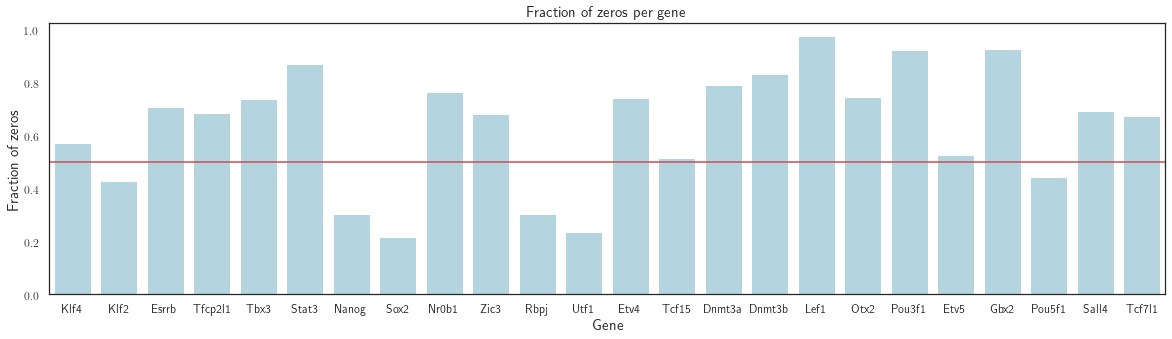

In [46]:
# show with an histogram the number of zero value for each gene
zeros_perGene_frac = np.sum(df_lN==0, axis=1)/df_lN.shape[1]
plt.figure(figsize=(20,5))
# barplot of the number of zeros per gene
sns.barplot(x=df_lN.index, y=zeros_perGene_frac, color='lightblue')

# add a line at 0.5
thr_zero = 0.5
plt.axhline(y=thr_zero, color='r', linestyle='-', label=thr_zero)
# plt.grid(True)
plt.title('Fraction of zeros per gene', fontsize=15)
plt.xlabel('Gene', fontsize=15)
plt.ylabel('Fraction of zeros', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



## Gene Expression in time

Raw gene expression

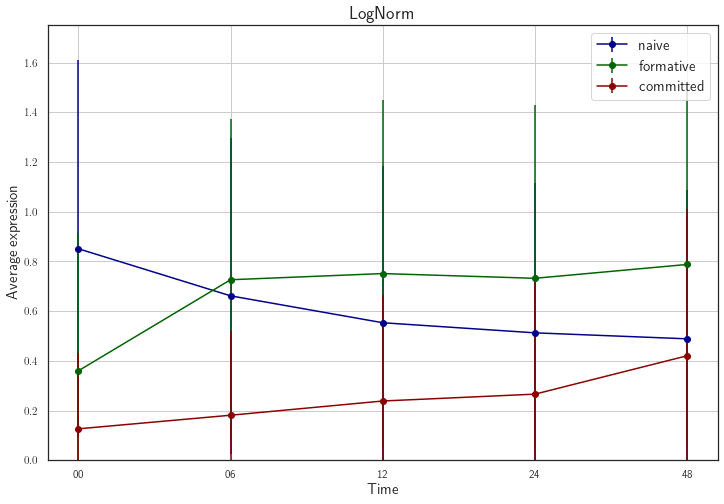

In [47]:
# Separate the different time step dataset and plot the average of the genes in each group
df_bulk_groups, df_std_groups, df_bulk, df_std = funcs_general.average_ge_in_time(df_lN, time_sep, ["naive", "formative", "committed", "others"], [naive, formative, committed, other], "LogNorm", plot_avg=True)


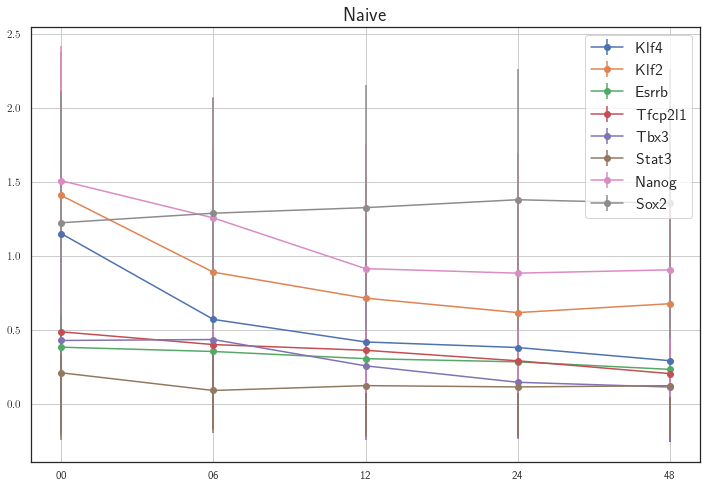

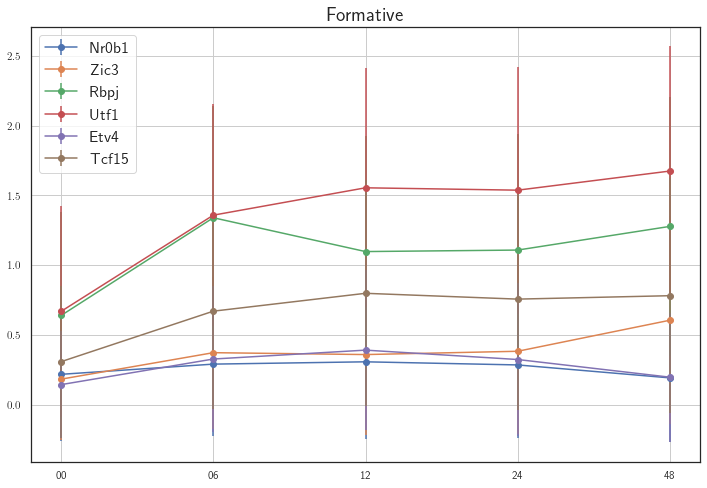

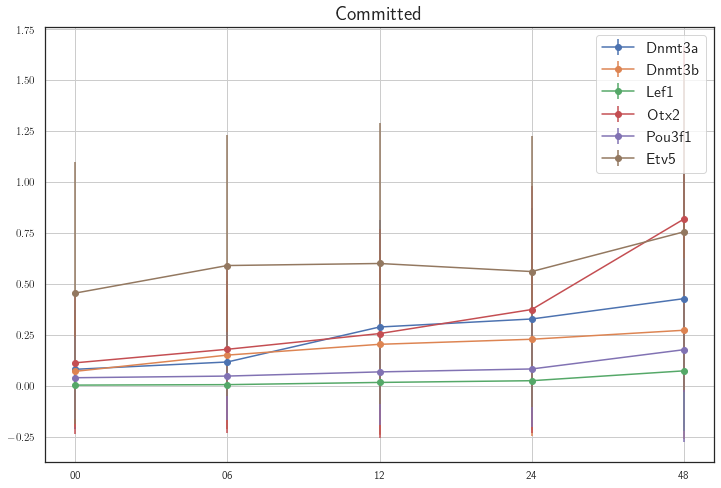

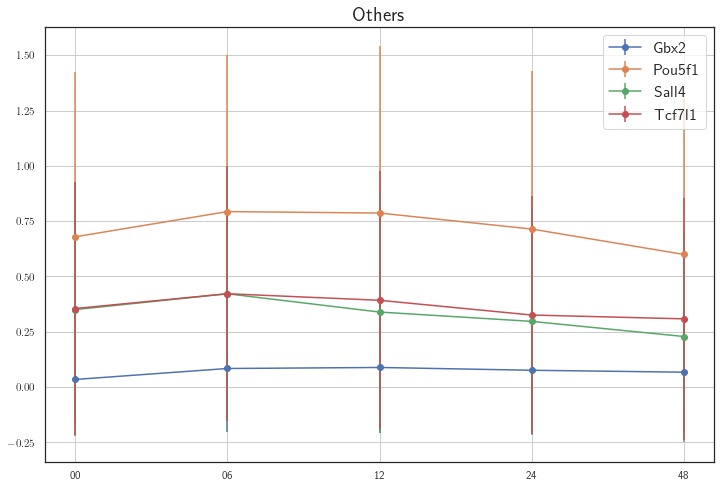

In [48]:
# # plot the gene expression for each gene in each group in time with theis std
funcs_general.plot_ge_in_time(df_bulk, df_std, [naive, formative, committed, other], ["Naive", "Formative", "Committed", "Others"])

## Pseudotime

Min pseudotime:  0.0 - Max pseudotime:  38.2221053912345
Number of cells in PST df:  9696


Text(0, 0.5, 'Density')

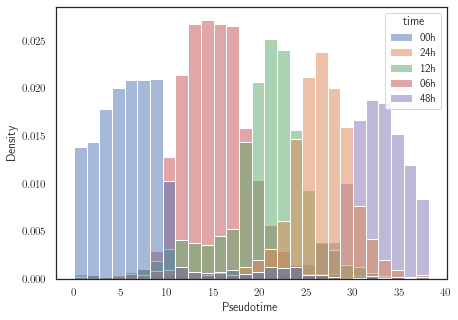

In [12]:
# Load PST Info dataframe: it links cell barcode to pseudotime
PST_df_lN = pd.read_csv(path_data+'input_data/cellinfo_pseudotime_3no2CLC_22_09_22.txt', 
                              header = 0, sep = ' ', quotechar = '"', 
                              names = ["barcodes", "time", "pst"]) # pst for LogNorm 

print("Min pseudotime: ", np.min(PST_df_lN["pst"]), "- Max pseudotime: ", np.max(PST_df_lN["pst"]))
print("Number of cells in PST df: ", PST_df_lN.shape[0])

# sorting in ascending values of pseudo-time
PST_df_lN = PST_df_lN.sort_values(by=['pst'])

# PLOT different times separated
plt.figure(figsize=(7,5))
sns.histplot(data=PST_df_lN, x="pst", hue="time", stat="density")
plt.xlabel("Pseudotime")
plt.ylabel("Density")


In [13]:

column_names = PST_df_lN["barcodes"]
df_lN_pst = df_lN.reindex(columns = column_names)

if saving:
    pd.DataFrame.to_csv(df_lN_pst, path_data + "GE_data/processed/imp_genes_LogNorm_PST.csv") 

# to load
# pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST.csv", header=0, index_col=0, sep=",")


## PST + MB

In [14]:
# Window size for Mini-Bulk
mb_wind = 150

# Threshold for half max
thr = 0.5 

In [15]:
# MB
df_lN_mb_pst = pd.DataFrame(df_lN_pst.rolling(window=mb_wind, axis=1).mean().dropna(axis=1), index=df_lN_pst.index)
df_lN_mb_pst.head(3)

# to save
if saving:
    pd.DataFrame.to_csv(df_lN_mb_pst, path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB.csv")


In [16]:
# Set the Flag to save or not the Figures showing the Gene Expression in time (with Mini-Bulk)
saving_fig=False
showing=False
count=0
if showing:
    # save the maximum value of each gene
    df_max = np.array(df_lN_mb_pst.max(axis=1))
    for ii in range(len(genes_order)):
        plt.figure(figsize=(10,5))     
        plt.plot(np.linspace(0, len(df_lN_mb_pst.iloc[ii,:]), len(df_lN_mb_pst.iloc[ii,:])), df_lN_mb_pst.iloc[ii,:])
        plt.axhline(y = df_max[ii]*thr, linestyle = 'dotted', color = "darkorange")
        plt.title(genes_order[ii])
        plt.ylim(0, df_max[ii]+0.1*df_max[ii])
        if saving_fig==True:
            plt.savefig("plot/halfmax_50/"+str(ii)+str(genes_order[ii])+"_gene.pdf")
        plt.show()
        print(genes_order[ii],df_max[ii]/2)
    count+=1

# PsiNorm Data

In [17]:
df_pN = pd.read_csv(path_data + "GE_data/imp_genes_PsiNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_pN.index.name = None

df_pN.head(3)


,AAACCCAGTGACCGTC,AAACGAAAGCGCGTTC,AAACGAACAAGCACCC,AAACGAATCAAGTCGT,AAACGCTTCCGTGACG,AAAGAACGTCAGATTC,AAAGAACTCACTTGTT,AAAGGATCAAATCAAG,AAAGGATTCTGAACGT,AAAGGGCAGCAGGCAT,...,TTTGACTGTCAGCTTA,TTTGACTGTGTTATCG,TTTGACTTCGCCACTT,TTTGATCGTTCTCCAC,TTTGGTTAGAGAGCGG,TTTGGTTGTGATCATC,TTTGGTTTCACGGGCT,TTTGGTTTCCAACACA,TTTGTTGCATCGAAGG,TTTGTTGCATCTCATT
Klf4,1.485415,1.338896,0.000000,0.855192,2.511880,1.881212,0.000000,1.267982,1.684245,0.000000,...,0.0,1.592437,1.025867,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
Klf2,1.485415,0.000000,1.338774,1.388465,0.000000,1.479866,2.463433,2.385357,1.075095,1.705082,...,0.0,2.008406,1.025867,0.0,0.0,0.0,2.182156,0.000000,0.0,1.578242
Esrrb,0.000000,1.338896,0.000000,1.388465,1.360576,0.000000,0.000000,1.267982,0.000000,0.000000,...,0.0,1.005610,0.000000,0.0,0.0,0.0,1.123956,0.952262,0.0,0.000000


## Pseudotime

In [18]:
# Load PST Info dataframe for Psi Norm: it links cell barcode to pseudotime
PST_df_pN = pd.read_csv(path_data+'input_data/cellinfo_pseudotime_UMAPno2clcs_23_01_13.txt',
                              header = 0, sep = ' ', quotechar = '"', 
                              names = ["barcodes", "time", "pst"])

print("Min pseudotime: ", np.min(PST_df_pN["pst"]), "- Max pseudotime: ", np.max(PST_df_pN["pst"]))
print("Number of cells in PST df: ", PST_df_pN.shape[0])

# sorting in ascending values of pseudo-time
PST_df_pN = PST_df_pN.sort_values(by=['pst'])



Min pseudotime:  0.0 - Max pseudotime:  26.2993780102351
Number of cells in PST df:  9732


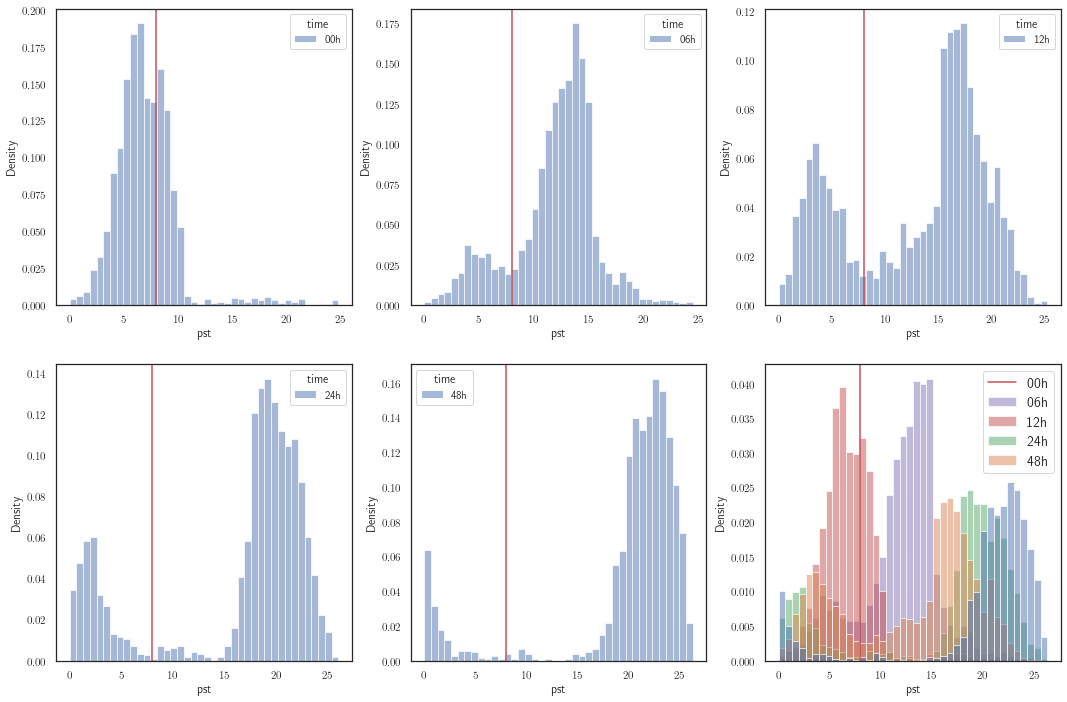

At 06h 0.1571486431753747
At 12h 0.2844957350727546
At 24h 0.20103686635944695
At 48h 0.10045366169799097


In [19]:
# plot PST for different REAL times 
fig, ax = plt.subplots(2,3,figsize=(18, 12))
sns.histplot(data=PST_df_pN[PST_df_pN["time"] == "00h"], x="pst", hue="time", stat="density", bins=40, ax=ax[0,0])
ax[0,0].axvline(x=8, color="r")
sns.histplot(data=PST_df_pN[PST_df_pN["time"] == "06h"], x="pst", hue="time", stat="density", bins=40, ax=ax[0,1])
ax[0,1].axvline(x=8, color="r")
sns.histplot(data=PST_df_pN[PST_df_pN["time"] == "12h"], x="pst", hue="time", stat="density", bins=40, ax=ax[0,2])
ax[0,2].axvline(x=8, color="r")
sns.histplot(data=PST_df_pN[PST_df_pN["time"] == "24h"], x="pst", hue="time", stat="density", bins=40, ax=ax[1,0])
ax[1,0].axvline(x=8, color="r")
sns.histplot(data=PST_df_pN[PST_df_pN["time"] == "48h"], x="pst", hue="time", stat="density", bins=40, ax=ax[1,1])
ax[1,1].axvline(x=8, color="r")
sns.histplot(data=PST_df_pN, x="pst", hue="time", stat="density", bins=40, ax=ax[1,2])
ax[1,2].axvline(x=8, color="r")
ax[1,2].legend(["00h", "06h", "12h", "24h", "48h"],loc='upper right', fontsize=14)
plt.show()

# fraction of cells < 8 at each time point
print("At 06h", 1-(np.sum(PST_df_pN["time"] == "06h") - np.sum([(PST_df_pN["time"] == "06h") & (PST_df_pN["pst"] < 8.0)]))/np.sum(PST_df_pN["time"] == "06h"))
print("At 12h", 1-(np.sum(PST_df_pN["time"] == "12h") - np.sum([(PST_df_pN["time"] == "12h") & (PST_df_pN["pst"] < 8.0)]))/np.sum(PST_df_pN["time"] == "12h"))
print("At 24h", 1-(np.sum(PST_df_pN["time"] == "24h") - np.sum([(PST_df_pN["time"] == "24h") & (PST_df_pN["pst"] < 8.0)]))/np.sum(PST_df_pN["time"] == "24h"))
print("At 48h", 1-(np.sum(PST_df_pN["time"] == "48h") - np.sum([(PST_df_pN["time"] == "48h") & (PST_df_pN["pst"] < 8.0)]))/np.sum(PST_df_pN["time"] == "48h"))


In [20]:
# Cutting bad inferred PST
PST_df_pN_new = PST_df_pN.copy()
PST_df_pN_new = PST_df_pN_new.drop(PST_df_pN_new[(PST_df_pN_new["time"] == "48h") & (PST_df_pN_new["pst"] < 8.0)].index)
PST_df_pN_new = PST_df_pN_new.drop(PST_df_pN_new[(PST_df_pN_new["time"] == "24h") & (PST_df_pN_new["pst"] < 8.0)].index)
PST_df_pN_new = PST_df_pN_new.drop(PST_df_pN_new[(PST_df_pN_new["time"] == "06h") & (PST_df_pN_new["pst"] < 8.0)].index)
PST_df_pN_new = PST_df_pN_new.drop(PST_df_pN_new[(PST_df_pN_new["time"] == "12h") & (PST_df_pN_new["pst"] < 8.0)].index)

# # Before cutting
# plt.figure(figsize=(7,5))
# sns.histplot(data=PST_df_pN, x="pst", hue="time", stat="density", bins=40)
# plt.xlabel("Pseudotime")
# plt.ylabel("Density")
# # After cutting
# plt.figure(figsize=(7,5))
# sns.histplot(data=PST_df_pN_new, x="pst", hue="time", stat="density", bins=40)
# plt.xlabel("Pseudotime")
# plt.ylabel("Density")

#saving the changed PST_df_pN
substitute = True
if substitute:
    PST_df_pN = PST_df_pN_new.copy()

## PST - reordering

In [21]:
# reordering dataframe using PST
column_names = PST_df_pN["barcodes"]
df_pN_pst = df_pN.reindex(columns = column_names)

df_pN_pst.head(3)

# to save
# saving = False
if saving: 
    pd.DataFrame.to_csv(df_pN_pst, path_data + "GE_data/processed/imp_genes_PsiNorm_PST.csv")


## PST + MB

In [22]:
# # same parameter as for logNorm, if you want to change, decomment here:
# mb_wind = 150    # Window size for Mini-Bulk
# thr = 0.5        # Threshold for the half-maximum

In [23]:
# MB implementation for PsiNorm
df_pN_mb_pst = pd.DataFrame(df_pN_pst.rolling(window=mb_wind, axis=1).mean().dropna(axis=1), index=df_pN_pst.index)
df_pN_mb_pst.head(3)

# to save
# saving=False
if saving:
    pd.DataFrame.to_csv(df_pN_mb_pst, path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB.csv")


In [24]:
# Set the Flag to save or not the figures
showing=False
saving_fig=False
if showing:
    # Plotting the half-maximum for each gene
    df_max = np.array(df_pN_mb_pst.max(axis=1))
    for ii in range(len(genes_order)):
        plt.plot(np.linspace(0, len(df_pN_mb_pst.iloc[ii,:]), len(df_pN_mb_pst.iloc[ii,:])), df_pN_mb_pst.iloc[ii,:])
        plt.axhline(y = df_max[ii]*thr, linestyle = 'dotted', color = "darkorange")
        plt.title(genes_order[ii])
        plt.ylim(0, df_max[ii]+0.1*df_max[ii])
        if saving_fig==True:
            plt.savefig("plot/halfmax_50/"+str(ii)+str(genes_order[ii])+"_gene.pdf")
        plt.show()
    #     print(df_max[ii],df_max[ii]/2)

# MB

In [25]:
# raw
df_raw_mb = mb.mov_avg(np.array(df_raw, dtype=int), wind=mb_wind)
df_raw_mb = pd.DataFrame(df_raw_mb, index=df_raw.index)

# log normalized
df_lN_mb = mb.mov_avg(np.array(df_lN, dtype=int), wind=mb_wind)
df_lN_mb = pd.DataFrame(df_lN_mb, index=df_lN.index)

# psi normalized
df_pN_mb = mb.mov_avg(np.array(df_pN, dtype=int), wind=mb_wind)
df_pN_mb = pd.DataFrame(df_pN_mb, index=df_pN.index)

if saving: 
    pd.DataFrame.to_csv(df_pN_mb_pst, path_data + "GE_data/processed/imp_genes_LogNorm_MB.csv")
    pd.DataFrame.to_csv(df_pN_mb_pst, path_data + "GE_data/processed/imp_genes_PsiNorm_MB.csv")


# Binarization (Half-max)

## LogNorm PST

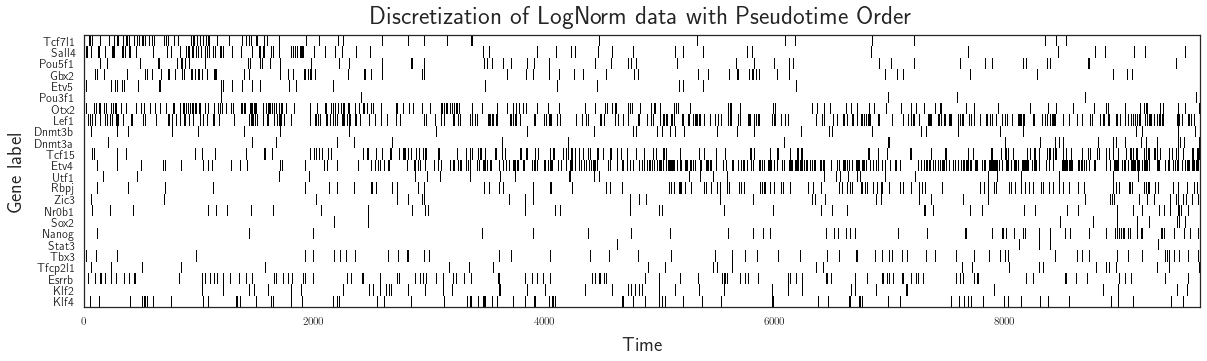

In [26]:
spins_df_lN_pst = funcs_general.binnarization(df_lN_pst, thr=thr, genes_order=genes_order)

fun_plotting.raster_plot(np.array(spins_df_lN_pst), 'Discretization of LogNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()

# to save
if saving: 
    pd.DataFrame.to_csv(spins_df_lN_pst, path_data + "GE_data/processed/imp_genes_LogNorm_PST_Spins.csv")


## PsiNorm MB

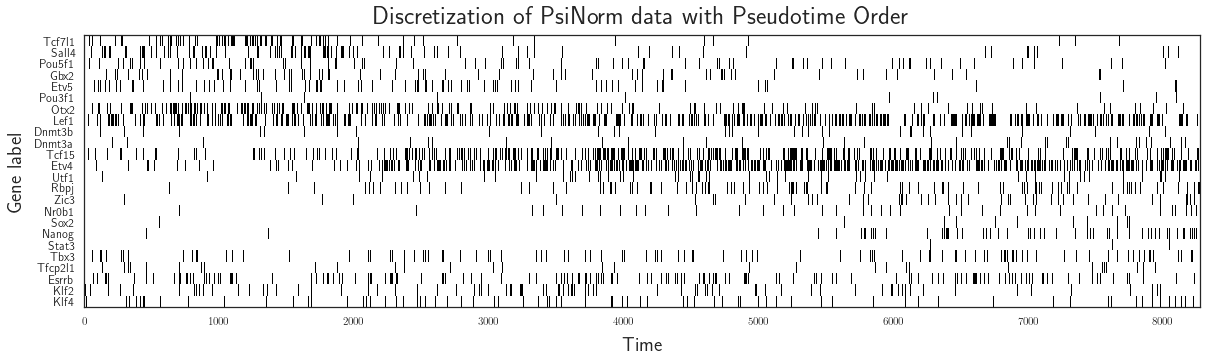

In [27]:
spins_df_pN_pst = funcs_general.binnarization(df_pN_pst, thr=thr, genes_order=genes_order)

fun_plotting.raster_plot(np.array(spins_df_pN_pst), 'Discretization of PsiNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()

# to save
if saving:
    pd.DataFrame.to_csv(spins_df_pN_pst, path_data + "GE_data/processed/imp_genes_PsiNorm_PST_Spins.csv")


## LogNorm PST MB

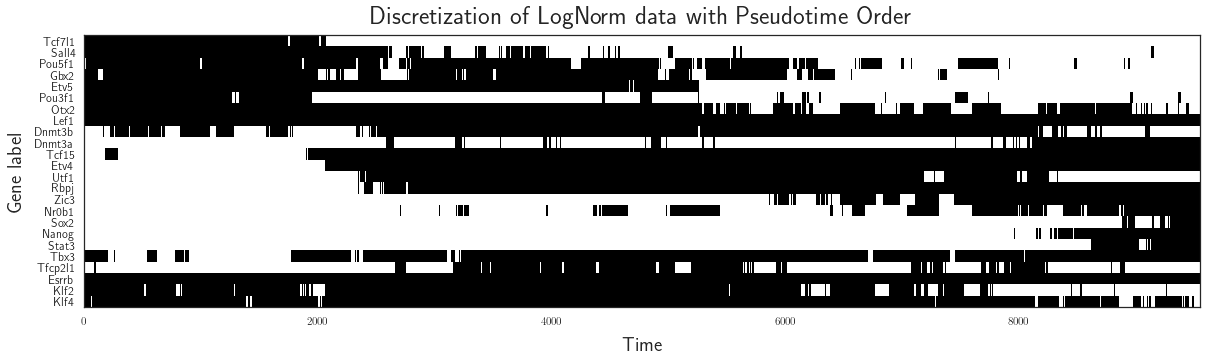

In [28]:
spins_df_lN_mb_pst = funcs_general.binnarization(df_lN_mb_pst, thr=thr, genes_order=genes_order)

fun_plotting.raster_plot(np.array(spins_df_lN_mb_pst), 'Discretization of LogNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()

# to save
if saving: 
    pd.DataFrame.to_csv(spins_df_lN_mb_pst, path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins.csv")


## PsiNorm PST MB

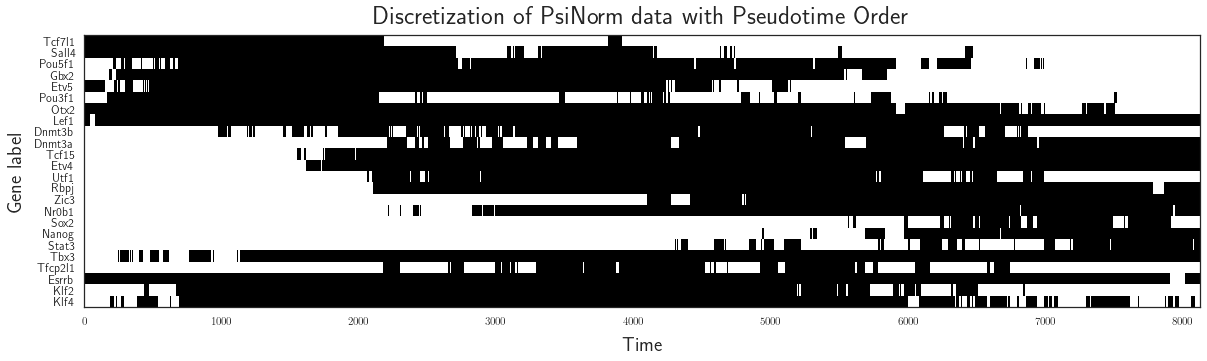

In [29]:
spins_df_pN_mb_pst = funcs_general.binnarization(df_pN_mb_pst, thr=thr, genes_order=genes_order)
fun_plotting.raster_plot(np.array(spins_df_pN_mb_pst), 'Discretization of PsiNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()

# to save
# saving = False
if saving:
    pd.DataFrame.to_csv(spins_df_pN_mb_pst, path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB_Spins.csv")


# Randomization

In [30]:
Ntest = 50

## LogNorm PST

In [31]:
N_rows = spins_df_lN_pst.shape[0]
N_cols = spins_df_lN_pst.shape[1]

# Linearize
val_rnd = np.reshape(np.array(spins_df_lN_pst), (N_cols*N_rows))

# reshuflle for Ntest times
spins_df_lN_pst_shuffle = np.zeros((Ntest, N_rows, N_cols))

for ii in range(Ntest):
    np.random.seed(1234+ii)
    # Random reshuffle of the binnarized GE data
    np.random.shuffle(val_rnd)
    val_rnd_matx = val_rnd.reshape(N_rows,N_cols) # Reshape to the original shape
    trial_long = pd.DataFrame(val_rnd_matx)

    # Save the shuffled DataFrame
    spins_df_lN_pst_shuffle[ii,:,:] = trial_long
    
# to save
if saving:  
    np.save(path_data + "GE_data/processed/imp_genes_LogNorm_PST_Spins_RND50Test.npy", spins_df_lN_pst_shuffle)
    
    


## PsiNorm PST

In [32]:
N_rows = spins_df_pN_pst.shape[0]
N_cols = spins_df_pN_pst.shape[1]

# Linearize
val_rnd = np.reshape(np.array(spins_df_pN_pst), (N_cols*N_rows))

# reshuflle for Ntest times
spins_df_pN_pst_shuffle = np.zeros((Ntest, N_rows, N_cols))

for ii in range(Ntest):
    np.random.seed(1234+ii)
    # Random reshuffle of the binnarized GE data
    np.random.shuffle(val_rnd)
    val_rnd_matx = val_rnd.reshape(N_rows,N_cols) # Reshape to the original shape
    trial_long = pd.DataFrame(val_rnd_matx)

    # Save the shuffled DataFrame
    spins_df_pN_pst_shuffle[ii,:,:] = trial_long
    
# to save
if saving:
    np.save(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_Spins_RND50Test.npy", spins_df_pN_pst_shuffle)


## LogNorm PST MB

In [33]:
N_rows = spins_df_lN_mb_pst.shape[0]
N_cols = spins_df_lN_mb_pst.shape[1]

# Linearize
val_rnd = np.reshape(np.array(spins_df_lN_mb_pst), (N_cols*N_rows))

# reshuflle for Ntest times
spins_df_lN_mb_pst_shuffle = np.zeros((Ntest, N_rows, N_cols))

for ii in range(Ntest):
    np.random.seed(1234+ii)
    # Random reshuffle of the binnarized GE data
    np.random.shuffle(val_rnd)
    val_rnd_matx = val_rnd.reshape(N_rows,N_cols) # Reshape to the original shape
    trial_long = pd.DataFrame(val_rnd_matx)

    # Save the shuffled DataFrame
    spins_df_lN_mb_pst_shuffle[ii,:,:] = trial_long
    
# to save
if saving: 
    np.save(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins_RND50Test.npy", spins_df_lN_mb_pst_shuffle)


## PsiNorm PST MB

In [34]:
N_rows = spins_df_pN_mb_pst.shape[0]
N_cols = spins_df_pN_mb_pst.shape[1]

# Linearize
val_rnd = np.reshape(np.array(spins_df_pN_mb_pst), (N_cols*N_rows))

# reshuflle for Ntest times
spins_df_pN_mb_pst_shuffle = np.zeros((Ntest, N_rows, N_cols))

for ii in range(Ntest):
    np.random.seed(1234+ii)
    np.random.shuffle(val_rnd) # Random reshuffle of the binnarized GE data
    val_rnd_matx = val_rnd.reshape(N_rows,N_cols) # Reshape to the original shape
    trial_long = pd.DataFrame(val_rnd_matx) # Convert to DataFrame

    # Save the shuffled DataFrame
    spins_df_pN_mb_pst_shuffle[ii,:,:] = trial_long     # Save the shuffled DataFrame
    
    
# to save
if saving:
    np.save(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB_Spins_RND50Test.npy", spins_df_pN_mb_pst_shuffle)



In [37]:
check=True
if check:
    # Check the reshuffle
    print(funcs_general.check_shuffle(spins_df_lN_pst_shuffle, Ntest))
    print(funcs_general.check_shuffle(spins_df_pN_pst_shuffle, Ntest))
    print(funcs_general.check_shuffle(spins_df_lN_mb_pst_shuffle, Ntest))
    print(funcs_general.check_shuffle(spins_df_pN_mb_pst_shuffle, Ntest))
    
    # zero expected if everithing is working fine

0.0
0.0
0.0
0.0


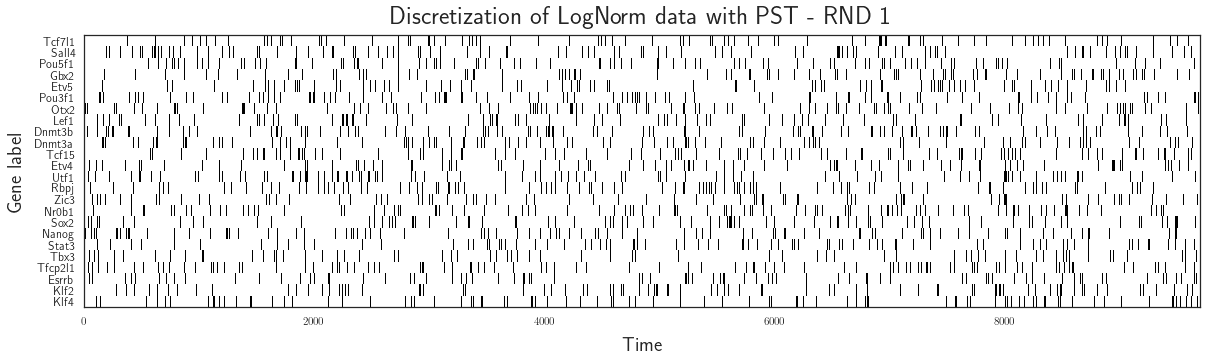

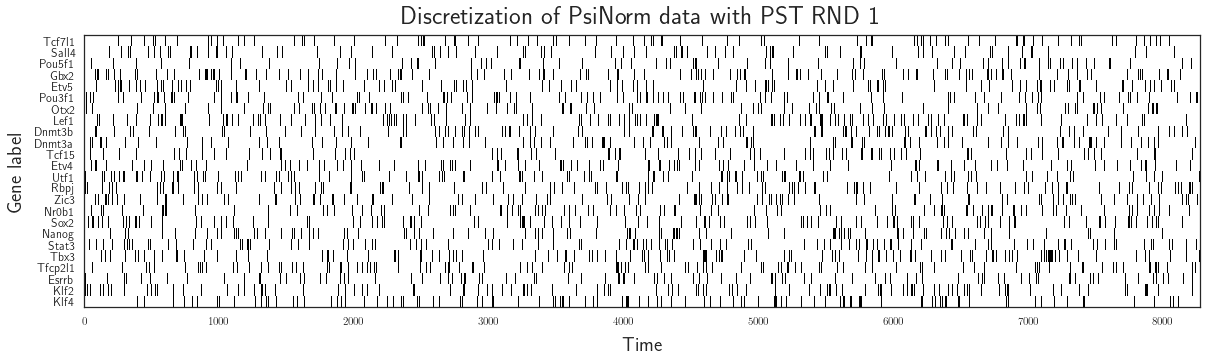

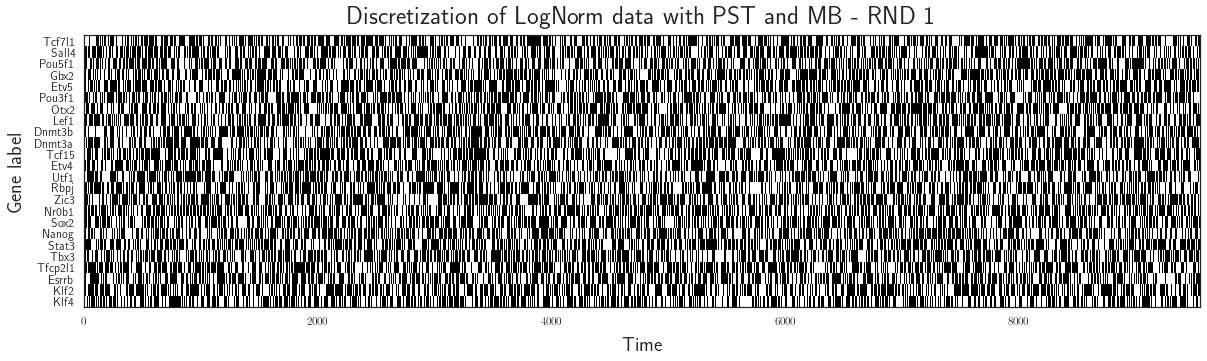

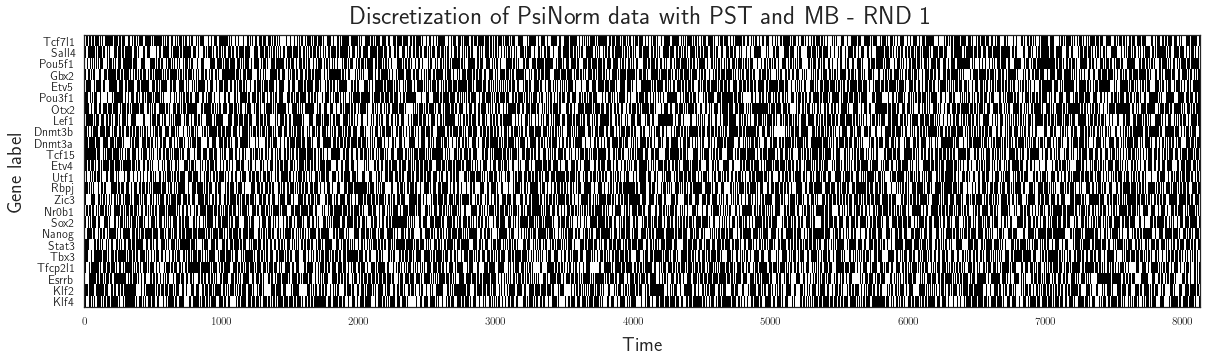

In [36]:
show_fig = True
if show_fig:
    for ii in range(0, Ntest, 60):
            fun_plotting.raster_plot(np.array(spins_df_lN_pst_shuffle[ii,:,:]), 'Discretization of LogNorm data with PST - RND '+str(ii+1), 1, genes_order[::-1])
            plt.show() 
            fun_plotting.raster_plot(np.array(spins_df_pN_pst_shuffle[ii,:,:]), 'Discretization of PsiNorm data with PST RND '+str(ii+1), 1, genes_order[::-1])
            plt.show() 
            fun_plotting.raster_plot(np.array(spins_df_lN_mb_pst_shuffle[ii,:,:]), 'Discretization of LogNorm data with PST and MB - RND '+str(ii+1), 1, genes_order[::-1])
            plt.show()    
            fun_plotting.raster_plot(np.array(spins_df_pN_mb_pst_shuffle[ii,:,:]), 'Discretization of PsiNorm data with PST and MB - RND '+str(ii+1), 1, genes_order[::-1])
            plt.show() 

